### Distance Measurement for our thesis titled, 

## AUTOMATED NERVE INJURY RISK EVALUATION IN MANDIBULAR THIRD MOLAR EXTRACTION BASED ON MAGLIONE’S CLASSIFICATION USING DEEP LEARNING

### with accuracy and precision metrics

In [1]:
# image_paths = [
#     './M3159-210/distance_Masked/d2.png',
#     './M3159-210/distance_Masked/d3.png',
#     './M3159-210/distance_Masked/d4.png',
#     './M3159-210/distance_Masked/d5.png',
#     './M3159-210/distance_Masked/d6.png',
#     './M3159-210/distance_Masked/d7.png',
#     './M3159-210/distance_Masked/d8.png',
#     './M3159-210/distance_Masked/d9.png',
# ]

image_paths = [
    './M3159-210/03-20-2024/re_dist2.png',
    './M3159-210/03-20-2024/re_dist3.png',
    './M3159-210/03-20-2024/re_dist4.png',
    './M3159-210/03-20-2024/re_dist5.png',
    './M3159-210/03-20-2024/re_dist6.png',
    './M3159-210/03-20-2024/re_dist7.png',
    './M3159-210/03-20-2024/re_dist8.png',
    './M3159-210/03-20-2024/re_dist9.png',
]

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import datetime
import os

#### Helper Functions

In [2]:
# Function to convert OpenCV BGR image to RGB
def convert_to_rgb_and_display(image, title):
    image_contour_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the images using Matplotlib
    plt.figure(figsize=(10, 5))
    
    # Display the contour result
    plt.imshow(image_contour_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
# Function to draw an arrow from the text to the point
def draw_arrow(image, text_position, point_position, color):
    # Draw the arrow
    cv2.arrowedLine(image, text_position, point_position, color, thickness=1, tipLength=0.1)

# Function to display a cropped portion of the image centered around the specified point
def display_zoomed_image(image, center_x, center_y, zoom_factor, title):
    height, width = image.shape[:2]
    
    # Calculate the size of the zoomed-in region
    zoom_width = int(width * zoom_factor)
    zoom_height = int(height * zoom_factor)
    
    # Define the top-left corner of the zoomed-in region
    x1 = max(0, center_x - zoom_width // 2)
    y1 = max(0, center_y - zoom_height // 2)
    
    # Define the bottom-right corner of the zoomed-in region
    x2 = min(width, center_x + zoom_width // 2)
    y2 = min(height, center_y + zoom_height // 2)
    
    # Crop the image to the zoomed-in region
    zoomed_image = image[y1:y2, x1:x2]
    
    # Resize the zoomed-in region to the original size
    zoomed_image = cv2.resize(zoomed_image, (width, height))

    convert_to_rgb_and_display(zoomed_image, title) # convert OpenCV BGR image to RGB and display
    
    # Display the zoomed-in image
    # cv2.imshow('Zoomed Image', zoomed_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

# Calculate distance between M3 and MC using Euclidean Distance formula
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

'''
- point1 and point2 are tuples representing the (x, y) coordinates of two points.
- The function uses the Euclidean distance formula: distance = sqrt((x2 - x1)^2 + (y2 - y1)^2).
'''

def filter_color(image, lower, upper):
    mask = cv2.inRange(image, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

'''
- cv2.inRange(image, lower, upper) creates a binary mask where pixels within the specified color range are set to 1 and others to 0.
- cv2.bitwise_and(image, image, mask=mask) applies the binary mask to the original image. It keeps only the pixels where the mask 
    is 1, effectively filtering out the colors outside the specified range.
- The filter_color function is used to filter regions of the image containing the colors of 
    interest (purple and green) and create a combined mask (combined_regions) that represents both color regions. The subsequent 
    processing involves converting this combined mask to grayscale and detecting contours, ultimately leading to the identification 
    of objects based on their color characteristics.
'''

'\n- cv2.inRange(image, lower, upper) creates a binary mask where pixels within the specified color range are set to 1 and others to 0.\n- cv2.bitwise_and(image, image, mask=mask) applies the binary mask to the original image. It keeps only the pixels where the mask \n    is 1, effectively filtering out the colors outside the specified range.\n- The filter_color function is used to filter regions of the image containing the colors of \n    interest (purple and green) and create a combined mask (combined_regions) that represents both color regions. The subsequent \n    processing involves converting this combined mask to grayscale and detecting contours, ultimately leading to the identification \n    of objects based on their color characteristics.\n'

#### Main driver

- Load image using OpenCV
    - Convert the image to HSV for better color segmentation

- Define the lower and upper bounds for the purple color
- Define the lower and upper bounds for the green color
- Filter out purple and green regions

1. COLOR FILTER
Green region points: 
[286 276], [286 277], [285 278], [279 278], [279 280], [278 281], [277 281], [277 282], [276 283], [272 283], [272 284], [271 285], [270 285], [270 286], [269 287], [268 287], [268 289], [267 290], [265 290], [265 291], [264 292], [261 292], [261 293], [260 294], [258 294], [258 296], [257 297], [256 297], [256 298], [255 299], [251 299], [251 300], [250 301], [240 301], [239 300], [239 299], [235 299], [234 298], [234 297], [231 297], [230 296], [230 294], [226 294], [225 293], [225 292], [212 292], [212 293], [211 294], [207 294], [207 296], [206 297], [203 297], [203 298], [202 299], [200 299], [200 300], [199 301], [198 301], [198 303], [197 304], [196 304], [196 307], [195 308], [193 308], [193 310], [192 311], [191 311], [191 317], [190 318], [189 318], [189 337], [190 337], [191 338], [191 344], [192 344], [193 345], [193 351], [195 351], [196 352], [196 356], [197 356], [198 357], [198 361], [199 361], [200 362], [200 365], [202 365], [203 

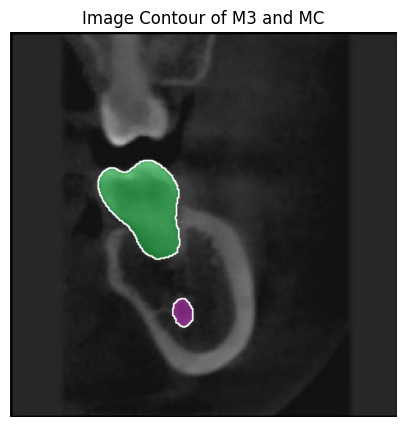

3. POINTS A AND B


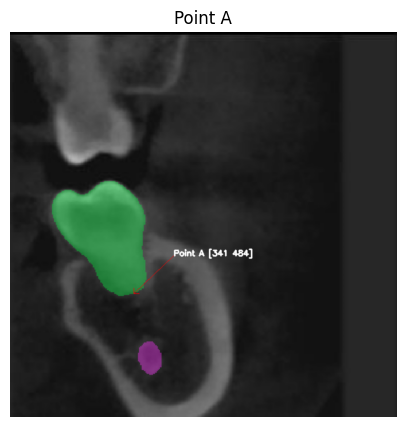

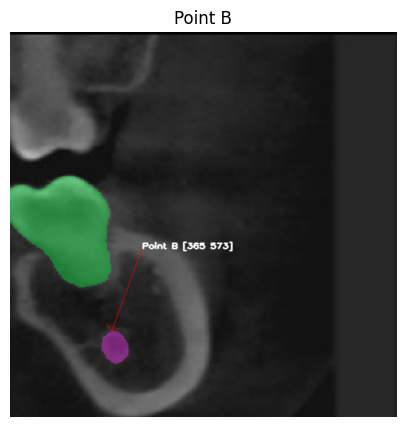

4. DISTANCE CALCULATION
Minimum distance in pixels: 
np.sqrt((341 - 365)**2 + (484 - 573)**2) = 92.17917335276988
Minimum distance in mm:
(min_distance * conversion_factor)
92.17917335276988 *  0.064 = 5.899467094577273
5. IMAGE WITH DISTANCE


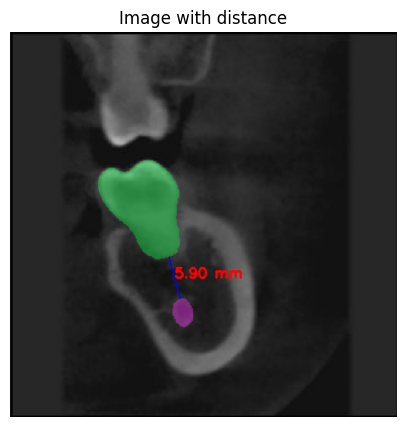

In [4]:
#169 - rgb(50,143,74) green , rgb(113,32,113) purple

#169_predicted - 

def detect_objects(image_path):
    # Load the image
    image = cv2.imread(image_path)
    filename = os.path.basename(image_path)
    
    # Convert the image to HSV for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the purple color
    lower_purple = np.array([130, 50, 50])
    upper_purple = np.array([170, 255, 255])

    # Define the lower and upper bounds for the green color
    lower_green = np.array([40, 40, 40])
    upper_green = np.array([80, 255, 255])

    # Filter out purple and green regions
    purple_regions = filter_color(hsv, lower_purple, upper_purple)
    green_regions = filter_color(hsv, lower_green, upper_green)

    # Combine the purple and green regions
    combined_regions = cv2.bitwise_or(purple_regions, green_regions)

    # Convert the combined image to grayscale
    gray = cv2.cvtColor(combined_regions, cv2.COLOR_BGR2GRAY)

    # Use a suitable method to detect objects, e.g., using contours
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours based on the topmost point of each contour
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[1])

    # Store points of each object in separate arrays
    object_points = []
    for contour in contours:
        points = np.array(contour[:, 0, :])
        object_points.append(points)

    # --- Color filter result ---
    print("1. COLOR FILTER")
    
    # display("Green region points: ", object_points[0]) # M3
    print("Green region points: ")
    for green in object_points[0]:
        print(green, end=', ')
    # display("Purple region points: ", object_points[1]) # MC
    print('')
    print("Purple region points: ")
    for purple in object_points[1]:
        print(purple, end=', ')
    print('')

    # --- Color filter result ---

    # --- Contour result ---
    print("2. CONTOUR")
    
    image_contour = image.copy()
    cv2.drawContours(image_contour,[object_points[0]],0,(255,255,255), thickness=2, lineType=cv2.LINE_AA) # M3
    cv2.drawContours(image_contour,[object_points[1]],0,(255,255,255), thickness=2, lineType=cv2.LINE_AA) # MC
    # Convert images to RGB format
    convert_to_rgb_and_display(image_contour, "Image Contour of M3 and MC")
    # --- Contour result ---

    # Calculate the least Euclidean distance between points of the two objects (this should be the true distance)
    min_distance = float('inf')
    point_a_min = None
    point_b_min = None
    # for point_a in object_points[0]:
    #     for point_b in object_points[1]:
    #         distance = calculate_distance(tuple(point_a), tuple(point_b))
    #         if distance < min_distance:
    #             min_distance = distance
    #             point_a_min = point_a
    #             point_b_min = point_b
    # Handle Exception
    try:
        for point_a in object_points[0]:
            for point_b in object_points[1]:
                distance = calculate_distance(tuple(point_a), tuple(point_b))
                if distance < min_distance:
                    min_distance = distance
                    point_a_min = point_a
                    point_b_min = point_b
    except IndexError as e:
        # print(f"An IndexError occurred: {e}")
        min_distance = 0

    # --- Point the point A and point B ---
    print("3. POINTS A AND B")
    
    # Point A in the minimum distance (in M3)
    image_point_a = image.copy()
    image_point_a[point_a_min[1], point_a_min[0]] = (255,255,255)
    text_position = (image_point_a.shape[1] // 2, image_point_a.shape[0] // 2)
    cv2.putText(image_point_a, f"Point A {point_a_min}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    draw_arrow(image_point_a, text_position, point_a_min, (0, 0, 255))
    # cv2.imshow("Point A", image_point_a)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # # Point B in the minimum distance (in MC)

    
    image_point_b = image.copy()
    image_point_b[point_b_min[1], point_b_min[0]] = (255,255,255)
    text_position = (image_point_b.shape[1] // 2, image_point_b.shape[0] // 2)
    cv2.putText(image_point_b, f"Point B {point_b_min}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    draw_arrow(image_point_b, text_position, point_b_min, (0, 0, 255))
    # cv2.imshow("Point B", image_point_b)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # --- Point the point A and point B ---

    # Zoom in on Point A
    display_zoomed_image(image_point_a, point_a_min[1], point_a_min[0], zoom_factor=0.9, title="Point A")
    
    # Zoom in on Point B
    display_zoomed_image(image_point_b, point_b_min[1], point_b_min[0], zoom_factor=0.9, title="Point B")

    # Display information about the detected objects
    # print(f"Points of Object 1: {object_points[0]}")
    # print(f"Points of Object 2: {object_points[1]}")
    # print(f"Least Euclidean Distance between Object 1 and Object 2: {min_distance} pixels")

    # Convert pixels to millimeter
    # 1 pixel = 0.2645833333 mm
    # print(min_distance)
    min_distance *= 0.064 # conversion factor for manually segmented
    # min_distance *= 0.15510299643 # conversion factor for predicted
    min_distance = min_distance if min_distance > 0.5 else 0

    # Draw a blue line connecting the closest points of the two objects
    if point_a_min is not None and point_b_min is not None:
        cv2.line(image, tuple(point_a_min), tuple(point_b_min), (255, 0, 0), 2)

        # Display the value of min_distance on top of the line
        text_position = ((point_a_min[0] + point_b_min[0]) // 2, (point_a_min[1] + point_b_min[1]) // 2)
    else:
        # If no points found, set distance to 0.0 and display it
        min_distance = 0.0
        # Position the text at the center of the image
        text_position = (image.shape[1] // 2, image.shape[0] // 2)

    # Display the distance on the image
    cv2.putText(image, f"{min_distance:.2f} mm", text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    # Generate file name with current date and time
    current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_filename = f"{current_datetime}_with_distance_overlay-{filename}.png"
    # Create the output directory if it doesn't exist
    output_directory = "./M3159-210/03-20-2024/with-distance-overlay/"
    # Check if the output directory exists, and create it if it doesn't
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # Save the modified image with distance overlayed to the specified directory
    output_path = os.path.join(output_directory, output_filename)
    cv2.imwrite(output_path, image)
    
    # Display the image with the connecting blue line
    # cv2.imshow("Image with distance", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    # --- DISTANCE CALCULATION ---
    print("4. DISTANCE CALCULATION")
    
    print("Minimum distance in pixels: ")
    pixel_distance = calculate_distance(point_a_min, point_b_min)
    print(f"np.sqrt(({point_a_min[0]} - {point_b_min[0]})**2 + ({point_a_min[1]} - {point_b_min[1]})**2) = {pixel_distance}")
    print("Minimum distance in mm:")
    print("(min_distance * conversion_factor)")
    print(f"{pixel_distance} *  0.064 = {min_distance}")
    # --- DISTANCE CALCULATION ---

    # --- IMAGE WITH DISTANCE ---
    print("5. IMAGE WITH DISTANCE")
    
    convert_to_rgb_and_display(image, "Image with distance")
    # --- IMAGE WITH DISTANCE ---

# detect_objects('./M3159-210/no/161.png')
# detect_objects('./M3159-210/distance_Masked/d2.png')
# detect_objects('./169_predicted.jpg')
# detect_objects('./193.png')
# detect_objects('./193_predicted.jpg')
# detect_objects('./M3159-210/distance_Masked2/re_dist6.png')
detect_objects('./M3159-210/03-20-2024/re_dist3.png')

    # return min_distance

##### For accuracy

In [3]:
# Accuracy
automatic_distances_measured = [] # results from the python script

for image_path in image_paths:
    automatic_distances_measured.append(detect_objects(image_path))
    
print(automatic_distances_measured)

[2.173174636332755, 5.899467094577273, 0.9163405480496867, 0, 9.04666656841071, 5.325861432669837, 0, 0]


##### For precision

In [4]:
# Standard Deviation Calculator
import statistics

def standard_deviation_calc(data, num):
    print("Image no. " + str(num) + ". Data", data)
    # Calculate mean
    mean = statistics.mean(data)
    print("Mean", mean)
    
    # Step-by-step calculation of standard deviation
    # Step 1: Calculate deviations from the mean
    deviations = [x - mean for x in data]
    print("Step 1: Deviations from the mean:", deviations)
    
    # Step 2: Square the deviations
    squared_deviations = [d ** 2 for d in deviations]
    print("Step 2: Squared deviations:", squared_deviations)
    
    # Step 3: Calculate the mean of squared deviations
    mean_squared_deviations = statistics.mean(squared_deviations)
    
    # Adjusted mean squared deviations for sample method
    adjusted_mean_squared_deviations = mean_squared_deviations * len(data) / (len(data) - 1)
    print("Step 3: Adjusted Mean of squared deviations:", adjusted_mean_squared_deviations)
    
    # Step 4: Calculate the square root of the adjusted mean squared deviations
    sample_standard_deviation = adjusted_mean_squared_deviations ** 0.5

    print("\nFinal Standard Deviation:", sample_standard_deviation)

    return sample_standard_deviation

In [5]:
def run_script_multiple_times(image_path, num_runs=10): # Function to run the script multiple times for each image
    script_distances = []
    for _ in range(num_runs):
        distance = detect_objects(image_path)
        script_distances.append(distance)
    return script_distances
    
def calculate_precision(script_distances_run_multiple_times_per_image, num): # Function to calculate precision using standard deviation function above
    return standard_deviation_calc(script_distances_run_multiple_times_per_image, num)

In [6]:
script_distances_multiple_runs = [] # List to store script distances for each image ran n times

for image_path in image_paths: # Run the script multiple times for each image
    distances = run_script_multiple_times(image_path)
    script_distances_multiple_runs.append(distances)

# display(script_distances_multiple_runs) # display

#### Measuring Precision and Accuracy

In [7]:
# Function to categorize precision based on standard deviation
def categorize_precision(std_dev):
    if std_dev < 0.5:
        return "High Precision"
    elif 0.5 <= std_dev < 1.0:
        return "Moderate Precision"
    else:
        return "Low Precision"

'''
    Determining what constitutes acceptable precision in your study depends on various factors 
including the specific requirements of your research, the nature of the measurements being taken, 
and the overall scope of your study. Here are some considerations to help you evaluate whether the categories are acceptable for your study:

1. Study Requirements: Consider the requirements of your study and the level of precision needed to achieve your research objectives. 
    Precision requirements can vary significantly depending on the nature of the study. For example, in medical studies involving 
    surgical procedures, higher precision may be necessary to ensure patient safety.

2. Clinical Relevance: Evaluate whether the level of precision achieved by your measurements is clinically relevant for your study. 
    Precision requirements can differ based on the clinical context and the potential impact of measurement errors on patient outcomes.

3. Previous Research: Review previous studies in your field to gain insights into typical levels of precision reported in similar 
    studies. This can help you establish benchmarks and determine whether the categories align with the expectations of your research community.

4. Instrumentation and Methodology: Consider the instrumentation and methodology used for measurements. Different measurement techniques 
    and instruments may have inherent limitations that affect precision. Ensure that your categories take these factors into account.

5. Practical Considerations: Assess whether the proposed categories align with practical considerations such as feasibility, resource 
    constraints, and the available technology. Striking a balance between precision requirements and practical constraints is 
    important for conducting research effectively.

6. Consultation with Experts: Seek input from domain experts, advisors, or colleagues with expertise in your research area. They 
    can provide valuable insights and help you validate the appropriateness of the proposed categories for your study.

    Ultimately, the acceptability of the proposed categories for precision depends on their alignment with the specific goals, requirements, 
    and constraints of your study. It's essential to critically evaluate these factors and make informed decisions to ensure that the 
    categories effectively capture the precision levels relevant to your research.
'''

"\n    Determining what constitutes acceptable precision in your study depends on various factors \nincluding the specific requirements of your research, the nature of the measurements being taken, \nand the overall scope of your study. Here are some considerations to help you evaluate whether the categories are acceptable for your study:\n\n1. Study Requirements: Consider the requirements of your study and the level of precision needed to achieve your research objectives. \n    Precision requirements can vary significantly depending on the nature of the study. For example, in medical studies involving \n    surgical procedures, higher precision may be necessary to ensure patient safety.\n\n2. Clinical Relevance: Evaluate whether the level of precision achieved by your measurements is clinically relevant for your study. \n    Precision requirements can differ based on the clinical context and the potential impact of measurement errors on patient outcomes.\n\n3. Previous Research: Revie

In [9]:
import pandas as pd

# Define a function to calculate precision and accuracy
def calculate_metrics(script_distances, ground_truth_distances, script_distances_multiple_runs):
    # Calculate precision
    precisions = []
    for i in range(len(script_distances_multiple_runs)):
        precision = calculate_precision(script_distances_multiple_runs[i], i+1)
        
        precisions.append(f"{precision} - {categorize_precision(precision)}")
        # print(precision)
    
    # Calculate accuracy
    
    accuracies = []
    # Accuracy = (1− true value/error) * 100
    for i in range(len(ground_truth_distances)):
        if ground_truth_distances[i] == 0 and ground_truth_distances[i] == script_distances[i]:
            accuracies.append('100%')
            continue
        accuracy = (1 - (abs(ground_truth_distances[i] - script_distances[i]) / ground_truth_distances[i])) * 100
        accuracies.append(str(round(accuracy, 2)) + '%')
    
    return precisions, accuracies

In [10]:
# Sample ground truth distances (in mm)
ground_truth_distances = [2.2, 4.9, 1.0, 0.0, 7.3, 4, 0.0, 0.0]

# Sample script distances (in mm)
script_distances = automatic_distances_measured

### Tabular Presentation of Precision and Accuracy

In [12]:
# Calculate precision and accuracy
precisions, accuracies = calculate_metrics(script_distances, ground_truth_distances, script_distances_multiple_runs)

# print(metrics)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Image': range(1, len(ground_truth_distances) + 1),
    'Ground Truth Distance (mm)': ground_truth_distances,
    'Script Distance (mm)': script_distances,
    'Precision (SD)': precisions,
    'Accuracy (%)': accuracies
})

# Print the DataFrame
display(results_df)

Image no. 1. Data [2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755, 2.173174636332755]
Mean 2.173174636332755
Step 1: Deviations from the mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Step 2: Squared deviations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Step 3: Adjusted Mean of squared deviations: 0.0

Final Standard Deviation: 0.0
Image no. 2. Data [5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273, 5.899467094577273]
Mean 5.899467094577273
Step 1: Deviations from the mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Step 2: Squared deviations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Step 3: Adjusted Mean of squared deviations: 0.0

Final Standard Deviation: 0.0
Image no. 3. Data [0.9163405480496867, 0.9163405

,Image,Ground Truth Distance (mm),Script Distance (mm),Precision (SD),Accuracy (%)
0,1,2.2,2.173175,0.0 - High Precision,98.78%
1,2,4.9,5.899467,0.0 - High Precision,79.6%
2,3,1.0,0.916341,0.0 - High Precision,91.63%
3,4,0.0,0.000000,0.0 - High Precision,100%
4,5,7.3,9.046667,0.0 - High Precision,76.07%
5,6,4.0,5.325861,0.0 - High Precision,66.85%
6,7,0.0,0.000000,0.0 - High Precision,100%
7,8,0.0,0.000000,0.0 - High Precision,100%
